In [1]:
# 이전에 사용했던 필요한 코드들

import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

<h1>8.1 합성곱 연산에 대해 알아봄</h1>

합성곱(convolution) 연산과 교차 상관(cross-correlation) 연산에 대해 알아봄.<br>

<h3>8.1.1 합성곱을 그림으로 이해함</h3>

합성곱은 두 함수에 적용하여 새로운 함수를 만드는 수학 연산자임.<br>

1. 배열 하나 선택해 뒤집기<br>

두 배열 x와 w가 있다고 가정하고 두 배열 중 원소수가 적은 배열 w의 원소 순서를 뒤집어 봄.<br>
뒤집은  배열은 reverse읭 약자인 r을 사용하여 w^r 이라고 표현함.

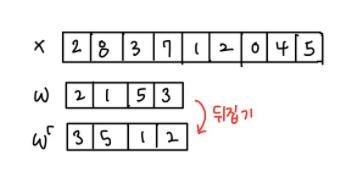

2. 첫 번째 합성곱<br>

뒤집은 배열을 배열 x의 왼쪽 끝자리에 맞춤.<br>
그 후 각 배열 원소끼리 곱한 후 더함. (점 곱 연산 수행)<br>

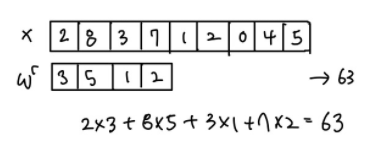

3. 위 방식으로 나머지 합성곱을 구함<br>

같은 방식으로 w^r을 오른쪽으로 한 칸씩 이동하여 x의 끝에 도착할 때까지 합성곱을 수행함.<br>
합성곱으로 얻은 값은 각각 63, 48, 49, 28, 21, 20임.<br>

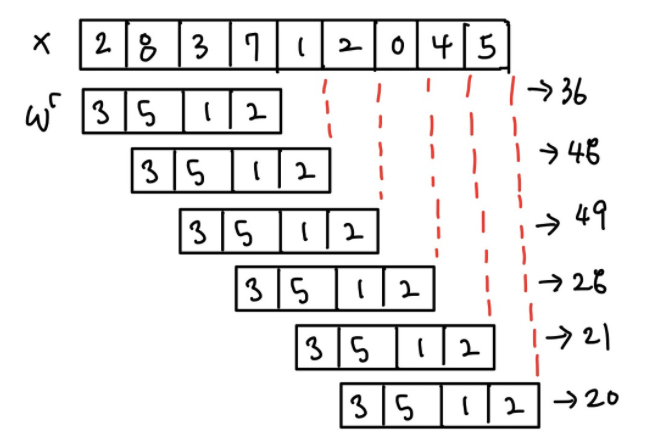

<h3>8.1.2 합성곱 구현하기</h3>

넘파이로 합성곱을 구현해 봄.<br>

1. 넘파이 배열 정의하고 배열 하나 선택해 뒤집기<br>

In [2]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

넘파이의 flip() 함수를 사용하면 배열을 간단하게 뒤집을 수 있음.

In [3]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


파이썬의 슬라이스 연산자로도 뒤집을 수 있음

In [4]:
w_r = w[::-1]
print(w_r)

[3 5 1 2]


2. 넘파이의 점 곱으로 합성곱 수행하기

In [5]:
for i in range(6) :
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


3. 싸이파이로 합성곱 수행하기<br>
싸이파이는 합성곱 함수 convolve를 제공함.

In [6]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

<h3>8.1.3 합성곱 신경망은 진짜 합성곱을 사용하지 않음</h3>
사실 대부분의 딥러닝 패키지는 합성곱 신경망을 만들 때 합성곱이 아닌 교차 상관을 사용함.<br>
이제 교차 상관을 알아봄.<br>

1.  합성곱과 교차상관은 아주 비슷함.<br>

교차 상관은 합성곱과 동일하게 진행되지만 '미끄러지는 배열을 뒤집지 않는다'는 점이 다름.<br>
즉 w_r이 아닌 w를 사용한다는 것임.<br>

교차 상관은 싸이파이의 correlate() 함수를 사용하면 간단하게 처리됨.

In [7]:
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

2. 합성곱 신경망에서 교차 상관을 사용하는 이유<br>

모델을 훈련할 때 가중치 배열을 초기화하는 과정을 생각해봄.<br>

모델 훈련 과정 간단 정리
<li>가중치를 무작위 값으로 초기화함</li>
<li>모든 샘플에 대해 정방향과 역방향 계산을 수행하여 가중치를 조금씩 학습(업데이트)함</li>

모든 모델은 훈련하기 전에 가중치 배열의 요소를 무작위로 초기화함.<br>
합성곱 신경망 모델도 같은 방식으로 '미끄러지는 배열'이 가중치에 해당하며 이를 무작위로 초기화함.<br>
따라서 가중치를 뒤집어서 합성곱을 적용하든지 뒤집지않고 교차 상관을 사용하든지 상관이 없음

<h3>8.1.4 패딩과 스트라이드</h3>

패딩(padding)은 원본 배열의 양 끝에 빈 원소를 추가하는 것.<br>
스트라이드(stride) 미끄러지는 배열의 간격을 조절하는 것.<br>
두 개념의 적용에 따라 밸리드 패딩, 풀 패딩, 세임 패딩으로 부르는데, 이를 알아봄.<br>

1. 밸리드 패딩은 원본 배열의 원소가 합성곱 연산에 참여하는 정도가 서로 다름.<br>
앞의 교차 상관을 싸이파이로 구현할 때 mode에 'valid'를 지정한 것이 밸리드 패딩을 적용한 것임.<br>
밸리드 패딩은 원본 배열에 패딩을 추가하지 않고 미끄러지는 배열이 원본 배열의 끝으로 갈 때까지 교차 상관을 수행함.<br>
이로 인해 밸리드 패딩의 결과로 얻는 배열의 크기는 원본 배열보다 항상 작음.<br>

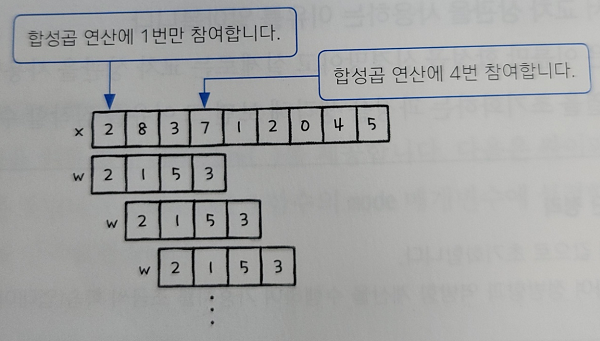

위 그림을 보면 원본 배열의 첫 번째 원소는 연산에 1번만 참여하는 반면, 네 번째 원소는 4번의 연산에 참여함.<br>
즉, 밸리드 패딩은 원본 배열 양 끝 원소의 연산 참여도가 낮음.

2. 풀 패딩은 원본 배열 원소의 연산 참여도를 동일하게 만듦.<br>

원본 배열의 원소가 연산에 동일하게 참여하려면 원본 배열의 양 끝에 가상의 원소를 추가함.<br>
이때 가상의 원소 0을 사용하므로 제로 패딩(zero padding)이라고 부름.<br>

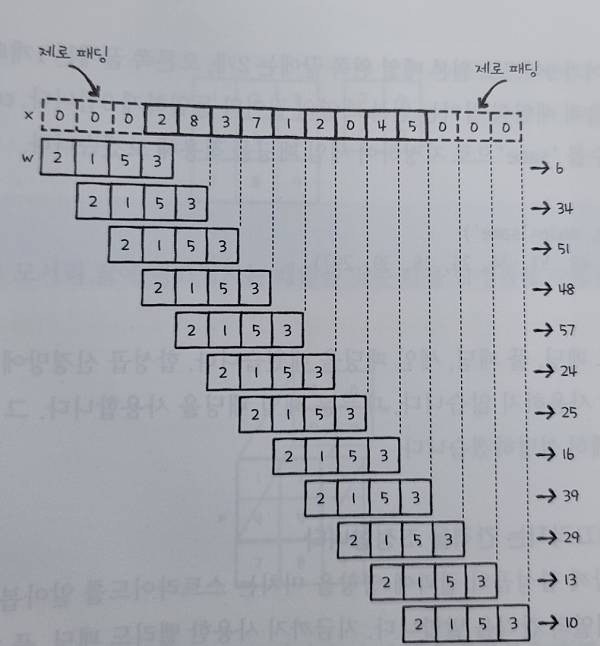

correlate() 함수에서 풀 패딩을 적용하려면 매개변수 mode를 'full'로 지정함.

In [8]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

3. 세임 패딩은 출력 배열의 길이를 원본 배열의 길이와 동일하게 만듦.<br>

세임 패딩은 다음 그림과 같이 출력 배열의 길이가 원본 배열의 길이와 같아지도록 원본 배열에 제로 패딩을 추가함.<br>
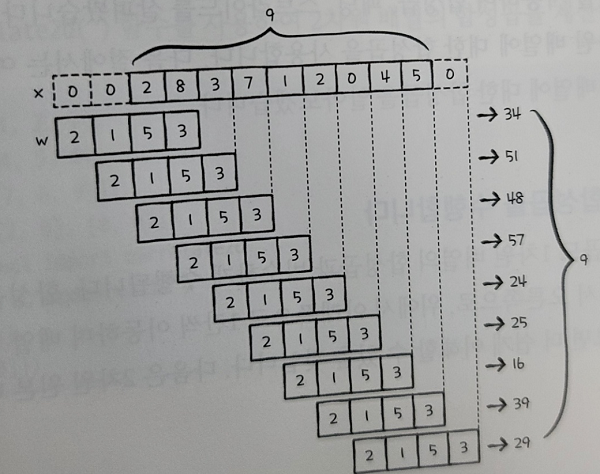

원본 배열의 길이가 9이므로 원본 배열 왼쪽 끝에 2개, 오른쪽 끝에 1개의 요소가 제로 패딩됨.<br>
correlate() 함수의 mode 매개변수를 'same'으로 지정하여 사용 가능.

In [9]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

합성곱 신경망에서는 대부분 세임 패딩을 사용함.<br>
(이유는 8.3 에서 설명)

4. 스트라이드는 미끄러지는 간격을 조정함.<br>

지금까지는 모두 1칸씩 미끄러지며 연산을 수행했음.<br>
즉, 스트라이드를 1로 지정하여 연산이 수행됨.<br>
만약 스트라이드를 2로 지정하면 2칸씩 미끄러지며 연산을 수행함.<br>

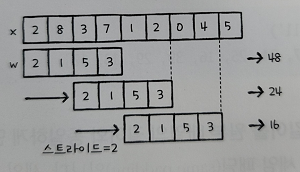

합성곱 신경망을 만들 때는 보통 스트라이드를 1로 지정함.<br>

<h3>8.1.4 2차원 배열에서 합성곱 수행</h3>

원본 배열 x와 미끄러지는 배열 w가 있음.<br>

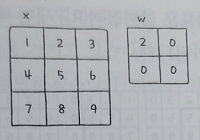

원본 배열의 왼쪽 모서리 끝에 미끄러지는 배열을 맞춘 다음 합성곱 수행.<br>

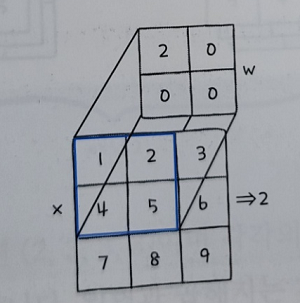

이후 아래와 같이 미끄러지며 진행함.<br>

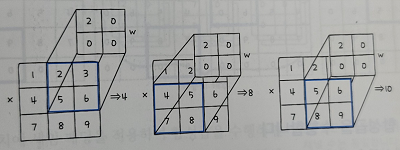

싸이파이의 correlate2d() 함수를 사용하여 2차원 배열의 합성곱을 계산해 봄.<br>

In [10]:
from scipy.signal import correlate2d
x = np.array([[1, 2, 3,],
             [4, 5, 6],
             [7, 8, 9]])
w = np.array([[2, 0],
             [0, 0]])
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

2차원 배열에서 세임 패딩의 경우엔 오른쪽과 아래쪽 모서리에 제로 패딩이 추가됨.

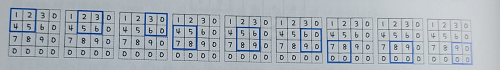

세임 패딩을 적용하는 방법은 다음과 같음.

In [11]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

스트라이드를 2로 지정한 2차원 배열은 다음과 같음.

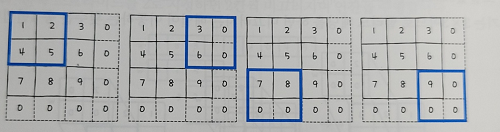

<h3>8.1.5 텐서플로로 합성곱을 수행함</h3>

이제부터는 합성곱 신경망을 기준으로 설명하므로 원본 배열을 입력, 미끄러지는 배열을 가중치라 부름.<br>

1. 합성곱 신경망의 입력은 일반적으로 4차원 배열임.<br>

텐서플로에서 2차원 합성곱을 수행하는 함수는 conv2d() 임.<br>
conv2d() 함수는 입력으로 4차원 배열을 기대함.<br>
그 이유는 입력 이미지의 높이와 너비 외에 더 많은 차원이 필요하기 때문임.<br>
구체적으로 입력으로 사용하는 4차원 배열의 모습은 아래와 같음.<br>

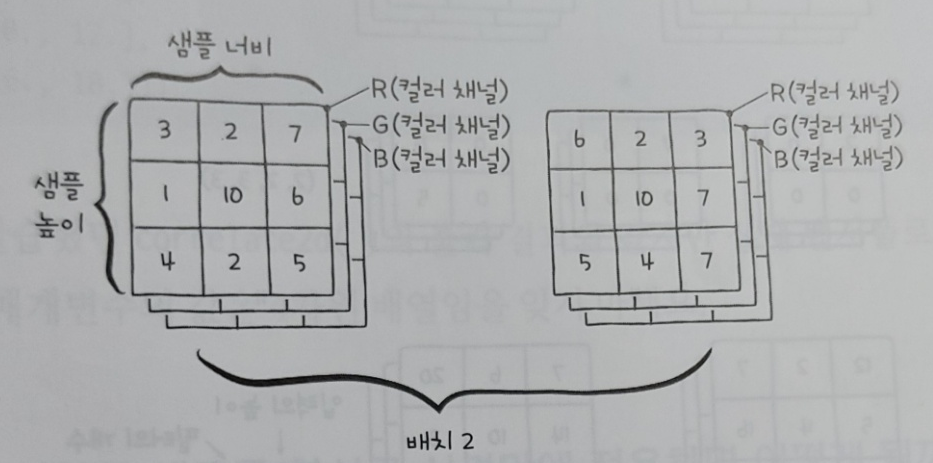

입력 2개의 샘플이 포함되어 있으며 각 샘플은 R, G, B로 구분되는 3개의 컬러 채널을 가짐.<br>
위 입력을 4차원 배열로 표현하면 (2, 3, 3, 3)이며 각각의 숫자는 배치, 샘플의 높이, 샘플의 너비, 컬러 채널의 차원을 의미함.<br>
입력과 곱해지는 가중치도 4개의 차원으로 구성됨.<br>
첫 번째, 두 번재 차원은 가중치의 높이와 너비이고, 세 번째 차원은 채널, 네 번째 차원이 가중치임.<br>
다음의 경우 (2, 2, 3, 3)으로 표현됨.<br>

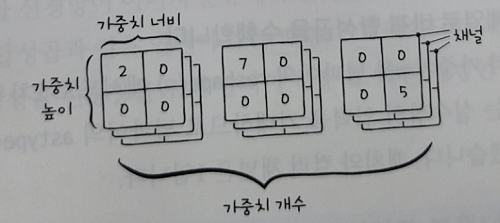

입력과 가중치에 세임 패딩을 적용하여 합성곱을 수행하면 (입력의 배치, 입력의 높이, 입력의 너비, 가중치의 개수)가 됨.<br>
이를 그림으로 정리하면 다음과 같음.<br>

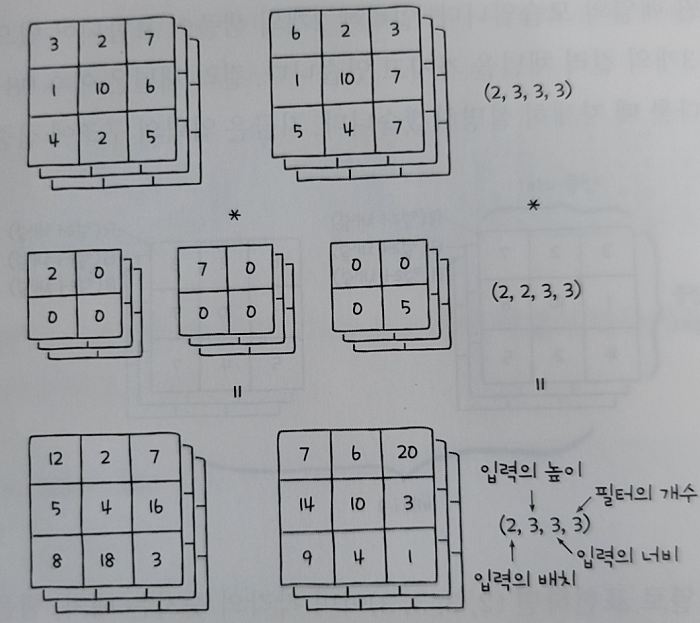

2. 2차원 배열을 4차원 배열로 바꿔 합성곱을 수행함.<br>

앞에서 사용한 입력 x와 가중치 w를 넘파이의 reshape() 메서드로 2차원 배열에서 4차원 배열로 바꾸고,<br>
텐서플로는 실수형의 입력을 기대하므로 넘파이의 astype() 메서드로 입력의 자료형을 실수로 바꿈.<br>
배치와 컬러의 채널은 1임.

In [12]:
import tensorflow as tf
x_4d = x.astype(np.float64).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

스트라이드는 1, 패딩은 세임 패딩을 적용함.<br>
텐서플로의 conv2d() 함수의 패딩 옵션은 대문자를 사용함.

In [13]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

conv2d() 함수는 결괏값으로 텐서플로의 Tensor 객체를 반환함.<br>
텐서플로에서는 다차원 배열을 텐서(tensor)라고 부름.<br>
Tensor 객체의 numpy() 메서드를 사용하면 텐서를 넘파이 배열로 변환할 수 있음.<br>
배치 차원과 컬러 차원을 제거하고 편의상 (3, 3) 크기로 변환하여 출력해봄.

In [14]:
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

<h3>8.1.6 패션 MNIST 데이터 세트를 합성곱 신경망에 적용해봄</h3>

합성곱 신경망에서는 28x28 크기의 입력을 펼치지 않고 그대로 사용하여 3x3 또는 5x5 크기의 가중치로 합성곱을 적용함.<br>
가중치 배열의 크기는 훨씬 작아졌고 입력의 특징을 잘 찾기 때문에 합성곱 신경망이 이미지 분류에서 뛰어난 성능을 발휘함.<br>

(공부할 때는 합성곱의 가중치가 1개를 지칭하는 것을 커널, 필터 전체를 지칭하면 가중치라고 함)

<h1>8.2 풀링 연산</h1>

합성곱 신경망에서는 합성곱이 일어나는 층을 합성곱층, 풀링이 일어나는 층을 풀링층이라고 부름.<br>
합성곱층과 풀링층에서 만들어진 결과를 특성 맵(feature map)이라고 부름.<br>
아래에 RGB 컬러 채널을 가진 입력 이미지가 합성곱층과 풀링층을 거치며 변환되는 과정을 나타냄.

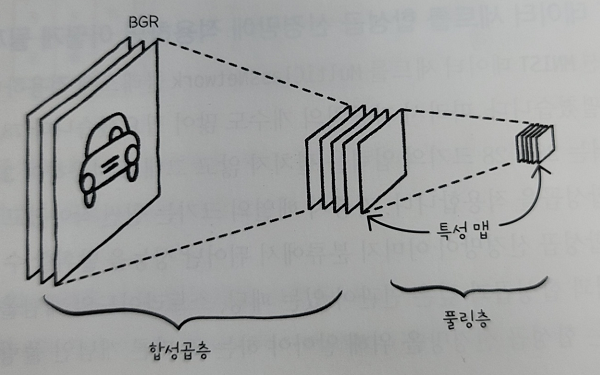

입력이 합성곱층을 통과할 때 합성곱과 활성화 함수가 적용되어 특성 맵이 만들어짐.<br>
그 후 다음 특성 맵이 풀링층을 통과하여 또 다른 특성 맵이 만들어짐.<br>
이렇게 합성곱층 뒤에 풀링층이 뒤따르는 형태는 합성곱 신경망의 전형적인 모습임.<br>

여기서 풀링이란 특성 맵을 스캔하며 최댓값을 고르거나 평균값을 계산하는 것을 의미함.<br>
다음은 특성 맵을 스캔하며 최댓값을 고르는 모습을 나타냄.

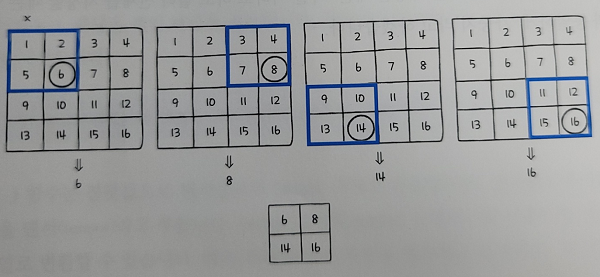

이를 최대 풀링이라 부름.<br>
합성곱 신경망에서는 최대 풀링과 평균 풀링을 주로 사용함.

<h3>8.2.1 최대 풀링(max pooling)에 대해 알아봄</h3>

최대 풀링은 특성 맵 위를 스캔하며 최댓값을 고름.<br>
풀링 영역의 크기는 보통 2x2를 지정함.<br>
일반적으로 스트라이드는 풀링의 한 모서리 크기로 지정하여 풀링 영역이 겹쳐지지 않도록 스캔함.<br>

2x2 풀링은 특성 맵의 크기를 절반으로 줄임.<br>
특성 맵의 크기를 절반으로 줄이면 특성 맵의 한 요소가 입력의 더 넓은 영역을 바라볼 수 있는 효과를 얻을 수 있음.<br>
예를 들어, 위 그림의 6, 8, 14, 16은 2x2 크기의 각 영역을 대표함.



<h3>8.2.2 평균 풀링(average pooling)에 대해 알아봄</h3>

평균 풀링은 풀링 영역의 평균값을 계산함.<br>

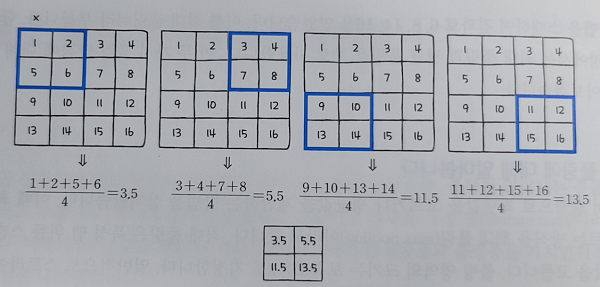

연구자들은 대체로 평균 풀링보다 최대 풀링을 선호함.<br>
최대 풀링을 선호하는 이유는 평균 풀링은 합성곱층을 통과하는 특징들을 희석시킬 가능성이 있기 때문임.<br>
즉, 입력에서 합성곱 필터가 찾고자 하는 부분은 특성 맵의 가장 큰 값으로 활성화되는데 평균 풀링은 가장 큰 특성의 값을 상쇄시키기 때문임.<br>
하지만 최대 풀링은 가장 큰 특징을 유지시키는 성질이 있으므로 이미지 분류 작업에 잘 맞음.

<h3>8.2.3 최대 풀링과 평균 풀링을 수행함</h3>

텐서플로의 max_pool2d() 함수를 사용하면 최대 풀링을 수행할 수 있음.<br>
max_pool2d() 함수의 매개변수 값으로 풀링 크기와 스트라이드만 전달하면 자동으로 최대 풀링을 수행하여 입력값을 반으로 줄여줌.<br>
다음은 1~16의 값이 들어 있는 4x4 크기의 배열을 만든 다음 1x4x4x1 크기의 배열로 변형한 것임.

In [15]:
x = np.array([[1, 2, 3, 4],
             [5, 6, 7, 8],
             [9, 10, 11, 12],
             [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

이제 max_pool2d() 함수로 최대 풀링을 수행함.<br>
풀링의 크기를 ksize 매개변수에, 스트라이드 크기를 strides 매개 변수에 동일한 값으로 지정함.<br>
max_pool2d() 함수가 반환한 Tensor 객체를 numpy() 메서드로 변환한 다음 2x2 크기의 2차원 배열로 변형함.

In [16]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

풀링층에는 학습되는 가중치가 없음.<br>
또한 풀링은 배치 차원이나 채널 차원으로 적용되지 않음.<br>
즉, 풀링층을 통과하기 전후로 배치 크기와 채널 크기는 동일함 (풀링은 각 샘플마다 또는 각 채널마다 독립적으로 수행됨)

<h1>8.3 합성곱  신경망의 구조를 알아봄</h1>

합성곱 신경망에서 자주 사용하는 활성화 함수는 렐루(ReLU) 함수임.

<h3>8.3.1 렐루 함수에 대해 알아봄</h3>

이전가지는 은닉층에 시그모이드 함수를 활성화 함수로 사용함.<br>
출력층은 이진 분류일 경우에는 시그모이드 함수를 사용하고, 다중 분류일 경우에는 소프트맥스 함수를 사용했음.<br>
렐루 함수는 주로 합성곱층에 적용되는 활성화 함수로, 합성곱 신경망의 성능을 높여줌.<br>
렐루 함수는 0보다 큰 값은 그대로 통과시키고 0보다 작은 값은 0으로 만듦.<br>

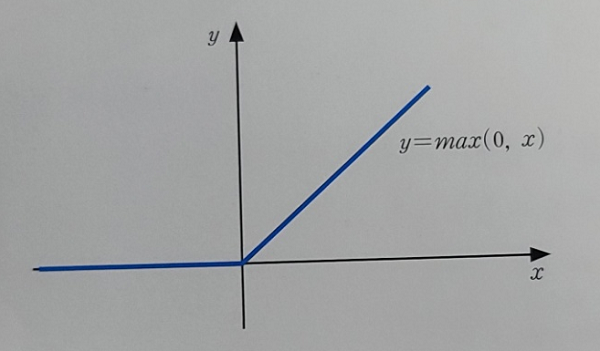

<h3>8.3.2 렐루 함수 구현하기</h3>

렐루 함수는 넘파이의 maximum() 함수를 사용해 간단하게 구현이 가능함.<br>

In [17]:
def relu(x) :
    return np.maximum(x, 0)

In [18]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

텐서플로가 제공하는 렐루 함수는 relu() 임.<br>
텐서플로의 렐루 함수는 Tensor 객체를 반환하므로 화면에 출력하려면 넘파이로 변환해야 함.

In [19]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

<h3>8.3.3 렐루 함수의 도함수를 알아봄</h3>

렐루 함수의 도함수는 다음과 같음.<br>

y = 1 (x>0) <br>
y = 0 (x<=0) <br>

x = 0인 경우 연속적이지 않지만 대부분 0으로 처리해도 잘 작동하므로 0으로 처리함.

<h3>8.3.4 합성곱 신경망에서 일어나는 일들과 구조를 알아봄</h3>

1. 합성곱 신경망에 주입될 입력 데이터에는 채널이 있음<br>

합성곱 신경망은 이미지의 2차원 형태를 입력으로 그대로 사용하므로 이미지를 한 줄로 펼칠 필요가 없음.<br>
이런 특성 때문에 이미지 정보가 손상되지 않는다는 장점이 있음.<br>
한 가지 고려할 점은 이미지는 채널이라는 차원을 하나 더 가진다는 것임.<br>

다음은 합성곱 신경망에서 사용할 입력 데이터를 그림으로 나타낸 것임.<br>

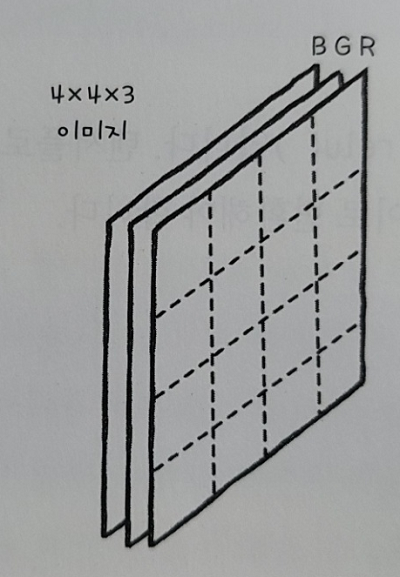

2. 합성곱층에서 일어나는 일을 알아봄.<br>

이미지의 모든 채널에 합성곱이 한 번에 적용되어야 하므로 커널의 마지막 차원은 입력 채널의 개수와 동일해야 함.<br>
각 커널의 크기는 보통 3x3 혹은 5x5임.<br>

만약 이미지가 4x4x3을 가진다면 커널의 크기는 3x3x3을 가져야 함.<br>
만약 이미지가 4x4x10을 가진다면 커널의 크기는 3x3x10을 가져야 함.<br>
(즉, 마지막 차원의 개수를 동일하게 맞추어야 함)<br>

다음은 합성곱의 전체 과정을 나타낸 것임.<br>

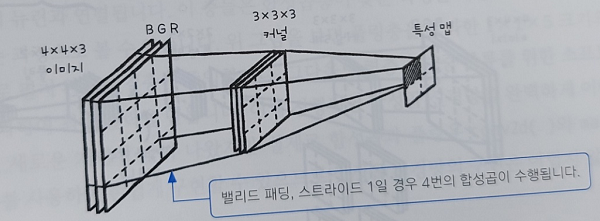

4x4x3 으로 구성된 이미지 위에 3x3x3 크기의 커널이 이동하며 합성곱을 4번 수행하므로 2x2 크기의 특성 맵이 만들어짐.<br>

3. 풀링층에서 일어나는 일을 알아봄.<br>

특성 맵이 만들어 졌으므로 이 특성 맵에 활성화 함수로 렐루 함수를 적용하고 풀링을 적용함.<br>

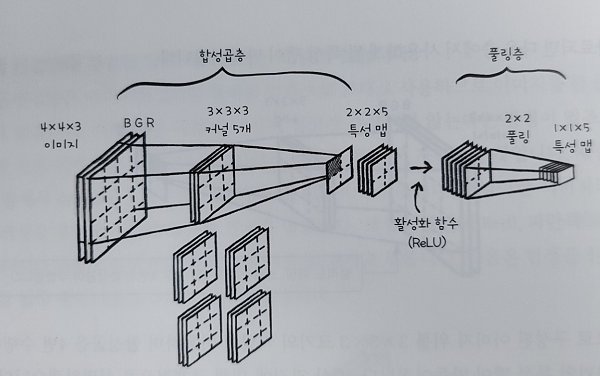

특성 맵에 렐루 함수가 적용된 후에 풀링이 적용됨.<br>
풀링은 특성 맵의 크기를 줄여주므로 맵의 크기가 2x2x5일 때 2x2 풀링이 적용되면 1x1x5 크기의 특성 맵이 만들어짐.<br>
물론 채널의 크기는 줄어들지 않음.

<h3>8.3.5 특성 맵을 펼쳐 완전 연결 신경망에 주입함</h3>

합성곱층과 풀링층을 통과시켜 얻은 특성 맵은 어떤 과정을 거칠까?<br>
일반적으로 합성곱층과 풀링층을 통과시켜 얻은 특성 맵은 일렬로 펼쳐 완전 연결층에 입력으로 주입함.<br>
다음은 합성곱층과 풀링층을 거쳐 만들어진 특성 맵이 완전 연결층에 주입되는 모습을 나타낸 그림임.<br>

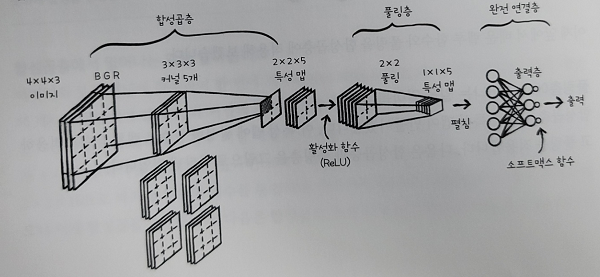

위와 같은 완전 연결층은 한 신경망 안에 여러 개가 들어 있을 수도 있음.<br>
완전 연결층의 출력은 출력층의 뉴런과 연결됨.<br>
이 층들은 합성곱층이 찾은 특성을 사용하여 최종 분류 단계를 수행하는 과정으로 볼 수 있음.<br>
위 그림을 보면 풀링층을 통과한 1x1x5 크기의 특성 맵을 일렬로 펼쳐 완전 연결층에 주입함.<br>

<h1>8.4 합성곱 신경망을 만들고 훈련함</h1>

텐서플로가 제공하는 합성곱 함수와 자동 미분 기능을 사용해 합성곱 신경망을 구현해 봄.<br>

<h3>8.4.1 합성곱 신경망의 전체 구조를 한 번 더 살펴봄</h3>

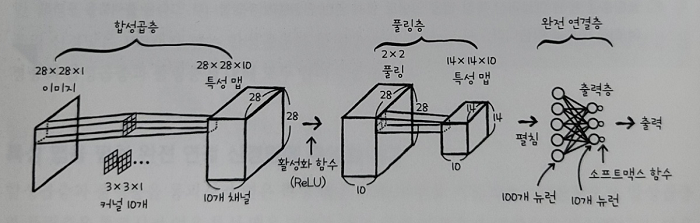

28x28 크기의 흑백 이미지와 3x3 크기의 커널 10개로 합성곱을 수행함.<br>
그런 다음 2x2 크기의 최대 풀링을 수행하여 14x14x10로 특성 맵의 크기를 줄임.<br>
이 특성 맵을 일렬로 펼쳐서 100개의 뉴런을 가진 완전 연결층과 연결시킴.<br>
그런 다음 10개의 클래스를 구분하기 위한 소프트맥스 함수를 연결함.<br>

<h3>8.4.2 합성곱 신경망의 정방향 계산 구현하기</h3>

구현할 합성곱 신경망 클래스는 ConvolutionNetwork임.<br>
이전에 구현한 클래스들과 대체로 비슷하지만, 합성곱과 렐루 함수 그리고 풀링이 적용된다는 점이 다름.<br>

정방향 계산을 담당하는 forpass() 메서드를 구현해봄.<br>
MultiClassNetwork 클래스의 forpass() 메서드에 있던 z1, a2, z2를 계산하는 식은 그대로 두고 그 앞에 합성곱과 풀링층을 추가하여 코드를 작성함.<br>

1. 합성곱 적용하기<br>
conv2d() 함수를 통해 합성곱을 수행한 다음 절편 self.conv_b를 더함.<br>
절편은 커널마다 1개씩 필요하므로 총 10개의 절편이 필요함.<br>
conv2d() 함수의 결과로 만들어지는 특성 맵의 크기는 28x28x10임.<br>
크기가 10인 1차원 배열 self.conv_b는 자동으로 conv2d(). 함수의 결과 마지막 차원에 브로드캐스팅됨.

In [20]:
"""
def forpass(self, x):
   3x3 합성곱 연산을 수행함
   c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding = 'SAME') + self.conv_b
"""

"\ndef forpass(self, x):\n   3x3 합성곱 연산을 수행함\n   c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding = 'SAME') + self.conv_b\n"

합성곱을 수행하는 conv2d() 함수에 전달한 매개변수 값은 다음과 같음.<br>
<li> self.conv_w</li>
합성곱에 사용할 가중치. 3x3x1 크기의 커널을 10개 사용하므로 가중치의 전체 크기는 3x3x1x10 임.<br>
<li> stride, padding</li>
특성 맵의 가로와 세로 크기를 일정하게 만들기 위하여 stride는 1, padding은 'SAME'으로 지정함.<br>

2. 렐루 함수 적용하기

In [21]:
"""
def forpass(self, x):
   렐루 함수를 적용함
   r_out = tf.nn.relu(c_out)
"""

'\ndef forpass(self, x):\n   렐루 함수를 적용함\n   r_out = tf.nn.relu(c_out)\n'

3. 풀링 적용하고 완전 연결층 수정하기<br>

max_pool2d() 함수를 사용하여 2x2 크기의 풀링을 적용함.<br>
이 단계에서 만들어진 특성 맵의 크기는 14x14x10임.<br>
풀링으로 특성 맵의 크기를 줄인 다음 tf.reshape() 함수를 사용해 일렬로 펼침.<br>
이때 배치 차원을 제외한 나머지 차원만 펼쳐야 함.<br>
그 다음 코드는 완전 연결층에 해당함.<br>
여기서는 np.dot() 함수를 텐서플로의 tf.matmul() 함수로 바꿈.<br>
이는 conv2d()와 max_pool2d() 등이 Tensor 객체를 반환하기 때문임.<br>
완전 연결층의 활성화 함수도 시그모이드 함수 대신 렐루 함수를 사용함.

In [22]:
"""
def forpass(self, x):
   ...
   2x2 최대 풀링을 적용함
   p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
   
   첫 번째 배치 차원을 제외하고 출력을 일렬로 펼침
   f_out = tf.reshape(p_out, [x.shape[0], -1])
   z1 = tf.matmul(f_out, self.w1) + self.b1        # 첫 번째 층의 선형식을 계산함
   a1 = tf.nn.relu(z1)                             # 활성화 함수 적용
   z2 = tf.matmul(a1, self.w2) + self.b2           # 두 번재 층의 선형식을 계산함
   return z2
"""

"\ndef forpass(self, x):\n   ...\n   2x2 최대 풀링을 적용함\n   p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')\n   \n   첫 번째 배치 차원을 제외하고 출력을 일렬로 펼침\n   f_out = tf.reshape(p_out, [x.shape[0], -1])\n   z1 = tf.matmul(f_out, self.w1) + self.b1        # 첫 번째 층의 선형식을 계산함\n   a1 = tf.nn.relu(z1)                             # 활성화 함수 적용\n   z2 = tf.matmul(a1, self.w2) + self.b2           # 두 번재 층의 선형식을 계산함\n   return z2\n"

<h3>8.4.3 합성곱 신경망의 역방향 계산 구현하기</h3>

그라디언트를 구하기 위해 역방향 계산을 직접 구현하는 대신 텐서플로의 자동 미분 기능을 사용함.<br>

1. 자동 미분의 사용 방법

In [23]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5
    
# 그라디언트 계산
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


텐서플로의 자동 미분 기능을 사용하려면 with 블럭으로 tf.GradientTape() 객체가 감시할 코드를 감싸야 함.<br>
tape 객체는 with 블럭 안에서 일어나는 모든 연산을 기록하고 텐서플로의 변수인 tf.Variable 객체를 자동으로 추적함.<br>

1. 역방향 계산 구현하기<br>
자동 미분 기능을 사용하면 backprop() 메서드를 구현할 필요가 없음.<br>

In [24]:
"""
def training(self, x, y):
   m = len(x)
   with tf.GradientTape() as tape:
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)
"""

'\ndef training(self, x, y):\n   m = len(x)\n   with tf.GradientTape() as tape:\n      z = self.forpass(x)\n      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)\n      loss = tf.reduce_mean(loss)\n'

training() 메서드에서 forpass() 메서드를 호출하여 정방향 계산을 수행한 다음 tf.nn.softmax_cross_entropy_with_logits() 함수를 호출해 정방향 계산의 결과(z)와 타깃(y)을 기반으로 손실값을 계산함.<br>
이 방법을 사용하면 크로스 엔트로피 손실과 그라디언트 계산을 올바르게 처리해 주므로 편리함.<br>
이때 softmax_cross_entropy_with_logits() 함수는 배치의 각 샘플에 대한 손실을 반환하므로 reduce_mean() 함수로 평균을 계산함.<br>

2. 그라디언트 계산하기<br>



가중치와 절편을 업데이트함.<br>
tape.gradient() 메서드를 사용하면 그라디언트를 자동으로 계산할 수 있음.<br>
합성곱층의 가중치와 절편인 con_w와 con_b를 포함하여 그라디언트가 필요한 가중치를 리스트로 나열함.<br>
그 다음 optimizer.apply_gradients() 메서드가 나옴.<br>
텐서플로는 여러 종류의 경사 하강법 알고리즘을 클래스로 미리 구현해 둠.<br>
텐서플로의 옵티마이저를 사용하면 간단하게 알고리즘을 바꾸어 테스트 가능함.<br>
(경사 하강법 알고리즘을 바꾸어 가며 테스트할 때 가중치 업데이트하는 코드를 일일히 바꾸면 번거로우므로)<br>
apply_gradients() 메서드에는 그라디언트와 가중치를 튜플로 묶은 리스트를 전달해야 함.<br>
이는 파이썬의 zip 반복자를 사용해 구현함.


In [25]:
"""
def training(self, x,  y):
   weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
   
   가중치에 대한 그라디언트 계산
   grads = tape.gradient(loss, weights_list)
   
   가중치 업데이트
   self.optimizer.apply_gradients(zip(grads, weights_list))
"""

'\ndef training(self, x,  y):\n   weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]\n   \n   가중치에 대한 그라디언트 계산\n   grads = tape.gradient(loss, weights_list)\n   \n   가중치 업데이트\n   self.optimizer.apply_gradients(zip(grads, weights_list))\n'

<h3>8.4.5 옵티마이저 객체를 만들어 가중치 초기화하기</h3>

training에 나오는 self.optimizer를 fit() 메서드에 SGD를 사용해 구현함.<br>

1. fit() 메서드 수정하기 <br>

텐서플로는 tf.optimizers 모듈 아래에 여러 종류의 경사 하강법이 있으며, SGD 옵티마이저는 기본 경사 하강법임.

In [26]:
class ConvolutionNetwork(ConvolutionNetwork):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

2. init_weights() 메서드 수정하기 <br>

가중치를 glorot_uniform() 함수로 초기화해야 하며 텐서플로의 자동 미분 기능을 사용하기 위해 가중치를 tf.Variable() 함수로 만들어야 함.<br>

합성곱의 가중치와 완전 연결층의 가중치를 tf.Variable() 함수로 선언할 때 입력값에 따라 자료형이 자동으로 결정됨.<br>
np.zeros() 함수는 기본적으로 64비트 실수를 만들며, 절편 변수를 가중치 변수와 동일하게 32비트 실수로 맞추기 위해 dtype 매개변수에 float을 지정함.

In [27]:
class ConvolutionNetwork(ConvolutionNetwork):
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수

<h3>8.4.6 glorot_uniform()을 알아봄</h3>

glorot_uniform() 함수는 가중치를 초기화할 때 글로럿 초기화라는 방법을 사용할 수 있게 해줌.<br>

지금까지는 넘파이로 난수를 만들어 초기화를 했는데 왜 글로럿 초기화를 사용하는가? <br>
출발점이 적절한 곳에 설정되면 전역 최적점이 아닌 지역 최적점으로 갈 수 있기 때문임.<br>

1. 글로럿 초기화 방식으로 가중치를 초기화함.<br>

텐서플로의 glorot_uniform() 함수는 <br>
-root(6/(입력 뉴런수 + 출력 뉴런수)) \~ root(6/(입력 뉴런수 + 출력 뉴런수)) <br>
사이에서 균등하게 난수를 발생시켜 가중치를 초기화함.<br>

사용법은 glorot_uniform() 함수에서 만든 객체를 호출할 때 필요한 가중치 크기를 전달함.<br>
init_weights() 메서드에서 conf_w, w1, w2 3개의 변수를 글로럿 방식으로 초기화 함.<br>

합성곱 영역의 너비와 높이는 3x3이고 흑백 이미지의 입력 채널은 하나이므로 커널의 크기는 3x3x1이 됨.<br>
이런 합성곱 커널을 n_kernels만큼 만들기 위해 3x3x1xn_kernels 크기의 4차원 배열로 초기화 함.<br>
합성곱과 풀링층을 거치면 입력 이미지의 높이와 너비가 28에서 14로 줄어듦.<br>
만들어진 특성 맵의 개수는 n_kernels임.<br>
이 배열이 일렬로 펼쳐져서 완전 연결층에 주입됨.<br>
이에 필요한 가중치 w1의 크기는 14x14xn_kernels가 됨.<br>

<h3>8.4.7 합성곱 신경망 훈련하기</h3>

1. 데이터 세트 불러오기<br>

In [28]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

2. 훈련 데이터 세트를 훈련 세트와 검증 세트로 나누기

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2,
                                                 random_state=42)

3. 타깃을 원-핫 인코딩으로 변환하기<br>

y_train, y_val은 정수로 이루어진 1차원 배열임.<br>
합성곱 신경망의 타깃으로 사용하려면 두 배열의 요소들을 원-핫 인코딩으로 변경해야 함.

In [31]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

4. 입력 데이터 준비하기 <br>
합성곱 신경망은 입력 데이터(이미지)를 일렬로 펼칠 필요가 없음.<br>
높이와 너비 차원을 그대로 유지한 채 신경망에 주입함.<br>
대신 마지막에 컬러 채널을 추가해야 함.<br>
흑백 이미지에는 컬러 채널이 없지만 명암을 나타내는 1차원 채널이 있다고 가정하고 넘파이 reshape() 메서드를 사용해 차원을 추가함.

In [32]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [33]:
x_train.shape

(48000, 28, 28, 1)

5. 입력 데이터 표준화 전처리하기 <br>

입력 데이터는 이미지이므로 0\~255 사이의 정수로 픽셀 강도를 표현함.<br>
경사 하강법을 사용하므로 입력 데이터를 255로 나누어 0\~1 사이의 값으로 조정함.<br>

In [34]:
x_train = x_train / 255
x_val = x_val / 255

6. 모델 훈련하기

In [35]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

7. 훈련, 검증 손실 그래프 그리고 검증 세트의 정확도 확인하기

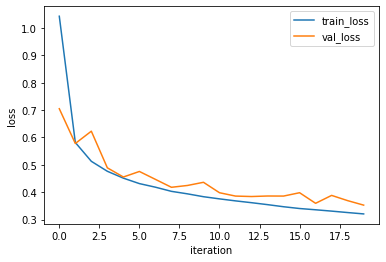

In [36]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [37]:
cn.score(x_val, y_val_encoded)

0.8773333333333333

<h1>8.5 케라스로 합성곱 신경망을 만듦</h1>

<h3>8.5.1 케라스로 합성곱 신경망 만들기</h3>

케라스의 합성곱층은 Conv2D 클래스임.<br>
최대 풀링은 MaxPooling2D 클래스를 사용하고, 특성 맵을 일렬로 펼칠 때는 Flatten 클래스를 사용함.<br>

1. 필요한 클래스들을 임포트하기 <br>

tensorflow.keras.layers에 포함된 Conv2D, MaxPooling2D, Flattern, Dense 클래스를 임포트함.

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

2. 합성곱층 쌓기<br>

Conv2D 클래스의 첫 번째 매개변수는 합성곱 커널의 개수임.<br>
두 번째 매개변수는 합성곱 커널의 크기로 높이와 너비를 튜플로 전달함.<br>
(전형적으로 3x3 이나 5x5를 많이 사용함)<br>
activation 매개변수에 렐루 활성화 함수를 지정함.<br>
패딩은 세임 패딩을 사용하는데, tf.nn.con2d() 함수와는 달리 패딩 매개변수는 대소문자를 구분하지 않음.<br>
Sequential 클래스에 층을 처음 추가할 때는 배치 차원을 제외한 입력의 크기를 지정함.

In [39]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

3. 풀링층 쌓기 <br>

MaxPooling2D 클래스의 첫 번째 매개변수는 풀링의 높이와 너비를 나타내는 튜플이며,<br>
스트라이드는 strides 매개변수에 지정할 수 있으며, 기본 값은 풀링의 크기임.<br>
패딩은 padding 매개변수에 지정하며 기본값은 'valid'임.

In [40]:
conv1.add(MaxPool2D((2, 2)))

4. 완전 연결층에 주입할 수 있도록 특성 맵 펼치기

In [41]:
conv1.add(Flatten())

5. 완전 연결층 쌓기

In [42]:
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

6. 모델 구조 살펴보기

In [43]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

<h3>8.5.2 합성곱 신경망 모델 훈련하기</h3>

1. 모델을 컴파일한 다음 훈련함.<br>

다중 분류를 위한 크로스 엔트로피 손실 함수를 사용하며, 정확도를 관찰하기 위해 metris 매개변수에 'accuracy'를 리스트로 전달함.<br>

In [44]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2. 아담 옵티마이저 사용하기 <br>

Adaptive Moment Estimation 을 줄여 아담이라고 하며, 아담은 손실 함수의 값이 최적값에 가까워질수록 학습률을 낮춰 손실 함수의 값이 안정적으로 수렴할 수 있게 함.

In [45]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4616 - accuracy: 0.8375 - val_loss: 0.3345 - val_accuracy: 0.8817
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3168 - accuracy: 0.8857 - val_loss: 0.2988 - val_accuracy: 0.8923
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2735 - accuracy: 0.9014 - val_loss: 0.2952 - val_accuracy: 0.8960
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2419 - accuracy: 0.9118 - val_loss: 0.2659 - val_accuracy: 0.9072
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2189 - accuracy: 0.9197 - val_loss: 0.2651 - val_accuracy: 0.9053
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1963 - accuracy: 0.9279 - val_loss: 0.2551 - val_accuracy: 0.9130
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1757 - accuracy: 0.9354 - val_loss: 0.2673 - val_accuracy:

3. 손실 그래프와 정확도 그래프 확인하기<br>


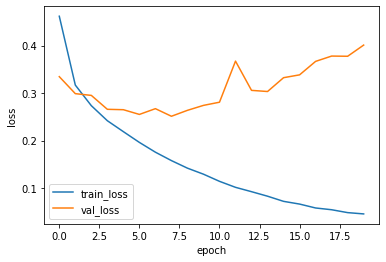

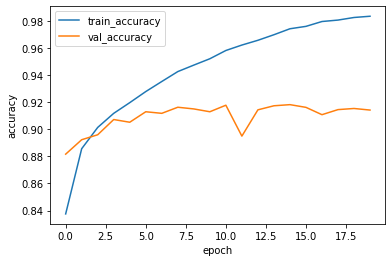

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

<h3>8.5.3 드롭아웃을 알아봄</h3>

신경망에서 과대적합을 줄이는 방법 중 하나는 드롭아웃임.<br>
드롭아웃은 무작위로 일부 뉴런을 비활성화시킴.<br>
무작위로 일부 뉴런을 비활성화시키면 특정 뉴런에 과도하게 의존하여 훈련하는 것을 막아줌.<br>
예로 축구선수를 들어봄.<br>

1. 축구 선수를 출전 목록에서 제외하는 것이 드롭아웃임.<br>

예를 들어 축구 경기에 출전할 선수 30명 중 일부 선수가 레드 카드를 받아 출전 목록에서 제외되었다면 어떻게 되는가? <br>
만약 개인 기량이 뛰어난 선수가 제외되었다면 전력에 큰 타격을 입음.<br>

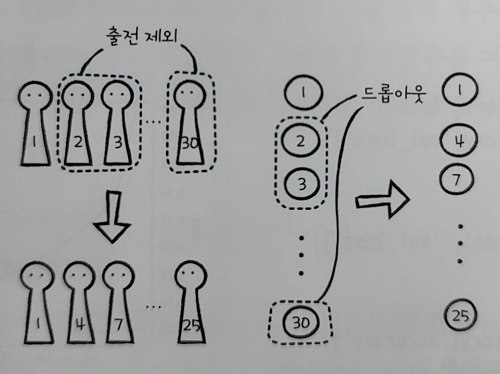

이 경우 개인 기량이 뛰어난 선수에게만 의존했던 전략을 다른 선수들에게도 고르게 훈련시키면 전력 손실을 최소화할 수 있음.<br>
드롭아웃도 이와 마찬가지로, 일부 뉴런이 비활성화 되었을 때에도 타깃을 잘 예측하려면 특정 뉴런에 과도하게 의존하지 않고 모든 뉴런이 의미있는 패턴을 학습해야 함.<br>
드롭아웃은 모델 훈련에만 사용하는 기법으로 테스트나 실전에서는 적용하지 않음.<br>
이로 인해 상대적으로 테스트와 실전의 출력값이 훈련할 때의 출력값보다 높아지므로 테스트나 실전에서는 출력값을 드롭아웃 비율만큼 낮춰야 함.<br>

2. 텐서플로에서는 드롭아웃의 비율만큼 뉴런의 출력을 높임 <br>

앞서서는 실전의 출력값을 드롭아웃 비율만큼 낮춰야 한다 함.<br>
그런데 대부분의 딥러닝 프레임워크는 반대로 이 문제를 해결함. <br>
즉, 훈련할 때 드롭아웃 비율만큼 뉴런의 출력을 높여 훈련시킴. <br>
원칙대로라면 테스트나 실전에서 출력을 낮춰야 하지만 이 방법을 이용해도 잘 작동함.<br>

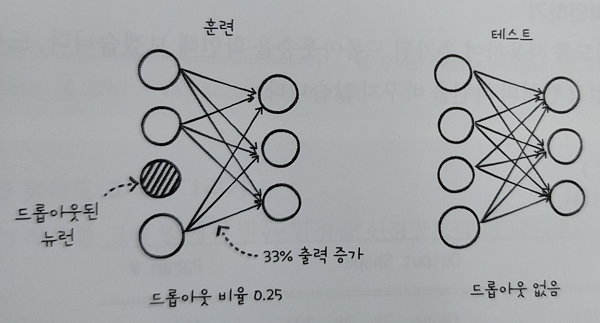

<h3>8.5.4 드롭아웃을 적용해 합성곱 신경망을 구현함</h3>

텐서플로에 적용하려면 Dropout 클래스를 추가하면 됨.<br>
Dropout 클래스의 매개변수에 드롭아웃될 비율을 실수로 지정함.<br>
(예를 들어 30%의 드롭아웃을 원하면 0.30을 전달함)<br>
드롭아웃층에는 학습되는 가중치가 없음.<br>
단순히 일부 뉴런의 출력을 무작위로 0으로 만들고 나머지 뉴런의 출력을 드롭되지 않은 비율로 나누어 증가시킴.<br>

1. 케라스로 만든 합성곱 신경망에 드롭아웃 적용하기<br>


In [48]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPool2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

2. 드롭아웃층 확인하기

In [49]:
conv2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dropout (Dropout)           (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                      

3. 훈련하기

In [50]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5162 - accuracy: 0.8123 - val_loss: 0.3514 - val_accuracy: 0.8789
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3802 - accuracy: 0.8615 - val_loss: 0.3095 - val_accuracy: 0.8898
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3410 - accuracy: 0.8767 - val_loss: 0.2939 - val_accuracy: 0.8930
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3128 - accuracy: 0.8844 - val_loss: 0.2761 - val_accuracy: 0.9012
Epoch 5/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2946 - accuracy: 0.8896 - val_loss: 0.2718 - val_accuracy: 0.8995
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2755 - accuracy: 0.8971 - val_loss: 0.2725 - val_accuracy: 0.8991
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2657 - accuracy: 0.9009 - val_loss: 0.2554 - val_accuracy:

4. 손실 그래프와 정확도 그래프 그리기

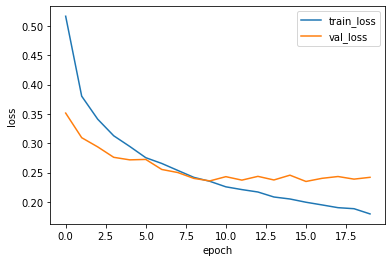

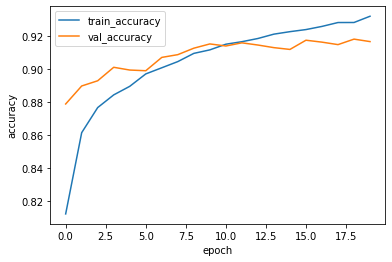

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

그래프를 보면 검증 손실이 증가되는 에포크가 낮아지고 훈련 손실과의 차이도 좁혀지며, 정확도가 미세하게 증가됨.